In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten

from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import keras

import cv2

from glob import glob
import os

In [2]:
def load_data(p):
    pattern= os.path.join(p,'*.png')
    fills= glob(pattern)
    x = []
    y = []
    for file in fills:
        char = list(os.path.splitext(os.path.basename(file))[0])
        if len(char)!=4:
            continue
        im = cv2.imread(file)
        im = (255-cv2.cvtColor(im,cv2.COLOR_RGB2GRAY))/255
        x.append(im)
        y.append(char)
    X = np.array(x)
    Y = np.array(y)
    return X,Y

In [3]:
x_train,y_train = load_data('../../part4_Machine Learning/Noron/2_1_Correlation/train/')
x_test,y_test = load_data('../../part4_Machine Learning/Noron/2_1_Correlation/test/')

In [4]:
encoder= LabelEncoder()
encoder.fit(y_train.reshape(-1))
encoder.classes_

with open('encoder.bin','wb')as f:
    pickle.dump(encoder,f)

In [5]:
y_encoded_train = encoder.transform(y_train.reshape(-1)).reshape(-1,4)
y_encoded_test = encoder.transform(y_test.reshape(-1)).reshape(-1,4)
print(y_encoded_train.shape)

(9843, 4)


In [6]:
def build_model():
    model= Sequential()

    model.add(Input(shape=(24,72,1)))

    model.add(Conv2D(4,(3,3),padding='same'))
    model.add(Conv2D(8,(3,3),padding='same'))
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(16,(3,3),padding='same'))
    model.add(Conv2D(32,(3,3),padding='same'))

    model.add(Flatten())
    model.add(Dense(256,activation='relu'))
    model.add(Dense(128,activation='relu'))

    model.add(Dense(32,activation='softmax'))

    # model.summary()
    model.compile('adam',loss='categorical_crossentropy',metrics=['accuracy'])
    return model
    
def fit_images(X,Y,XT,YT):
    yt = to_categorical(Y)
    yt_test = to_categorical(YT)
    model = build_model()
    res= model.fit(X,yt,validation_data=(XT,yt_test),epochs=5,verbose=False)
    train_acc = model.evaluate(X,yt)
    test_acc = model.evaluate(XT,yt_test)
    return model,res,train_acc,test_acc

In [7]:
def chart(res):
    plt.figure(figsize=(15,5))


    plt.subplot(1, 2, 1)
    plt.plot(res.history['accuracy'])
    plt.plot(res.history['val_accuracy'])
    plt.legend(['train', 'test'])

    plt.subplot(1, 2, 2)
    plt.plot(res.history['loss'])
    plt.plot(res.history['val_loss'])
    plt.legend(['train', 'test'])

4/4 [==============================] - 0s 6ms/step - loss: 0.1194 - accuracy: 0.9400


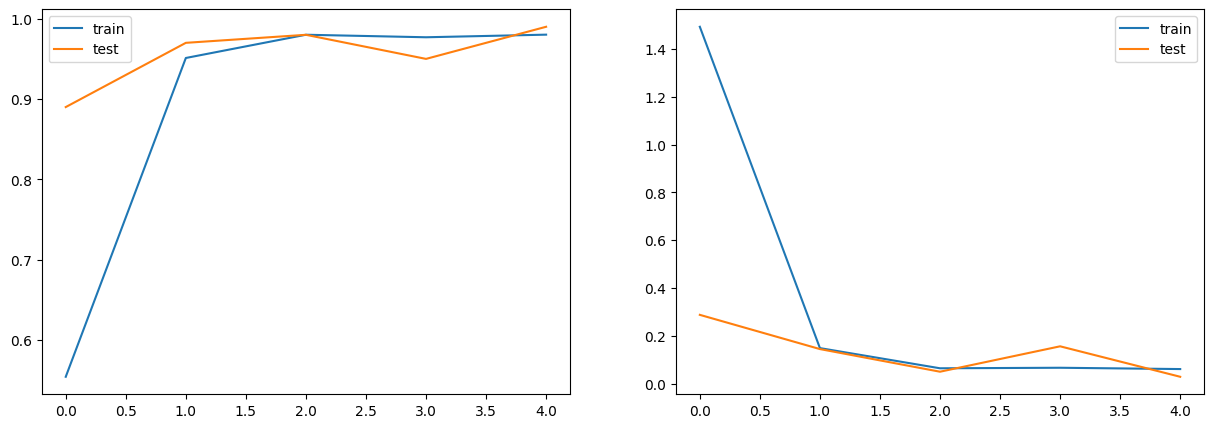

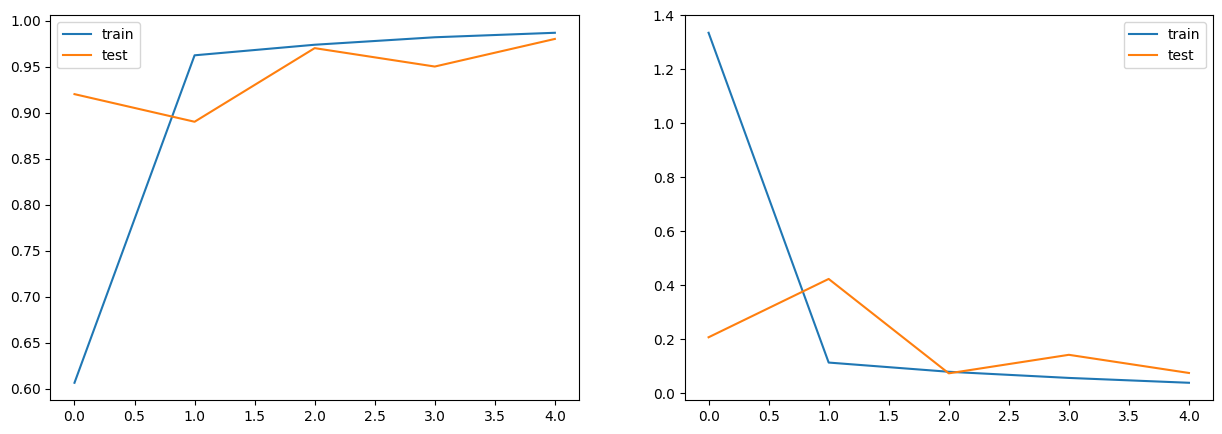

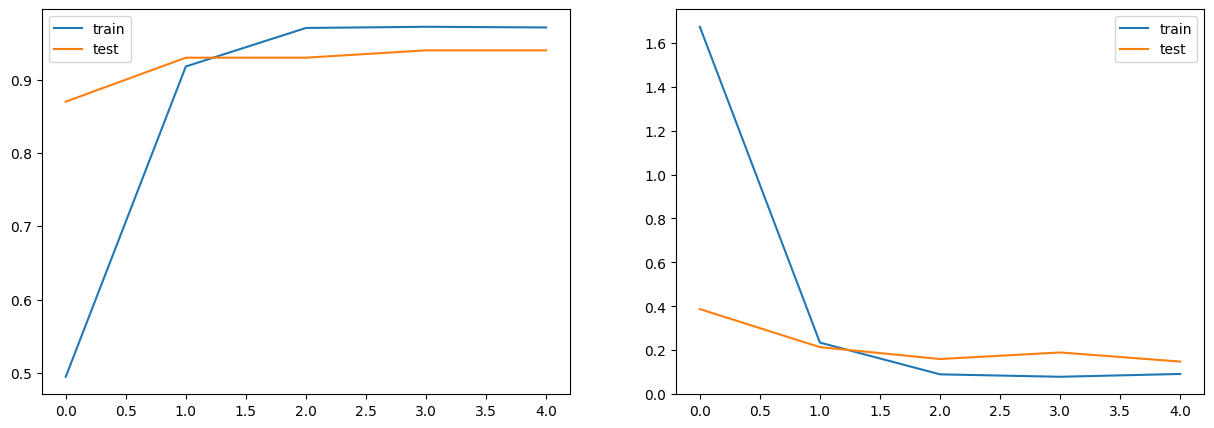

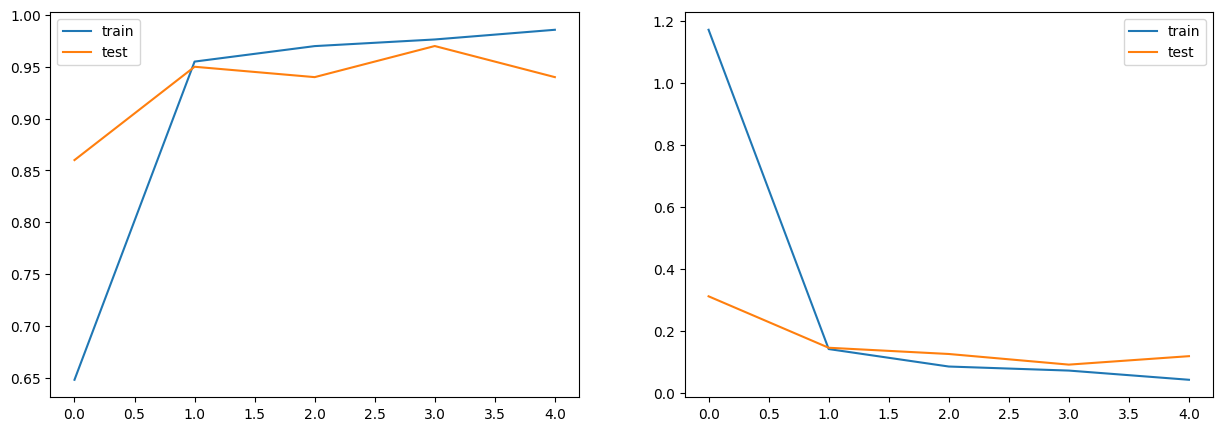

In [8]:
models = []
for i in range(4):

    model,res,train_acc,test_acc = fit_images(x_train,y_encoded_train[:,i],x_test,y_encoded_test[:,i])
    # chart(res)
    models.append(model)

In [59]:


def predect(f):
    im = cv2.imread(f)
    im = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    im = (255-im)/255
    
    with open('encoder.bin','rb')as f:
        encoder = pickle.load(f)
        
        
    models = []
    char = []
    for i in range(4):
        models.append(keras.models.load_model(f'model_{i}.h5')) 
        p = models[i].predict(im.reshape(1,24,72,1),verbose=False)
        p = np.argmax(p)
        p = encoder.inverse_transform([p])[0]
        char.append(p)
        

    plt.imshow(im,'gray');


    
    return (''.join(char))

'C7G3'

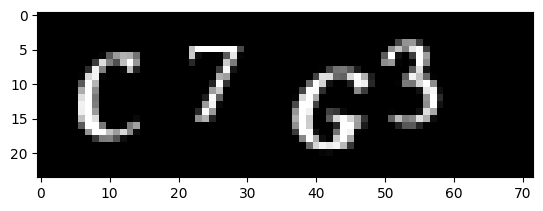

In [60]:
f = '../../part4_Machine Learning/Noron/2_1_Correlation/test/C7G3.png'
out = predect(f)
out

In [11]:
for i in range(4):
    models[i].save(f'model_{i}.h5')